In [2]:
from IPython.display import clear_output
!pip install tensorflow==2.7.0
clear_output()

In [3]:
from IPython.display import clear_output
!pip install tensorflow-quantum==0.6.0 --use-deprecated=legacy-resolver
clear_output()

In [ ]:
import numpy as np 
import sympy as sp
import pandas as pd
import tensorflow as tf
import tensorflow_quantum as tfq
import cirq
from cirq.contrib.svg import SVGCircuit
# import quple
from h5py import File as HDF5File
from PIL import Image
import matplotlib.cm as cm
from matplotlib.colors import LogNorm, Normalize
%matplotlib inline
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive

drive.mount('/content/gdrive/', force_remount=True)

Mounted at /content/gdrive/


In [ ]:
electron_datafile = '/content/gdrive/MyDrive//electron.hdf5'
photon_datafile = '/content/gdrive/MyDrive//photon.hdf5'

In [ ]:
electron_data = HDF5File(electron_datafile, 'r')
photon_data = HDF5File(photon_datafile, 'r')

In [ ]:
print(electron_data.keys())

<KeysViewHDF5 ['X', 'y']>


In [ ]:
jet_mass_datafile = '/content/gdrive/MyDrive//jet-images_Mass60-100_pT250-300_R1.25_Pix25.hdf5'
jet_mass_data = HDF5File(jet_mass_datafile, 'r')

In [ ]:
print(jet_mass_data.keys())

<KeysViewHDF5 ['image', 'jet_delta_R', 'jet_eta', 'jet_mass', 'jet_phi', 'jet_pt', 'signal', 'tau_1', 'tau_2', 'tau_21', 'tau_3', 'tau_32']>


(872666, 25, 25)


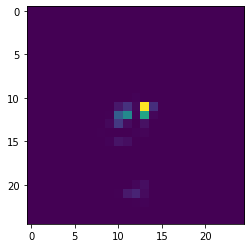

In [ ]:
X_jet = jet_mass_data['image']
print(X_jet.shape)
plt.imshow(X_jet[5,:,:])

In [ ]:
max_val_pix = np.argmax(np.mean(X_jet[:, :, :], axis=0))
print("Maximum pixel value for Jet mass images:",max_val_pix)
center = [int(max_val_pix/25), max_val_pix%25]

img_size = 8
X_jet = X_jet[:100, (center[0]-int(img_size/2)):(center[0]+int(img_size/2)), (center[1]-int(img_size/2)):(center[1]+int(img_size/2))]

print(X_jet.shape)

Maximum pixel value for Jet mass images: 312
(100, 8, 8)


In [ ]:
def plot_jet_image(content,
#                     output_name,
                    vmin=1e-6,
                    vmax=300,
                    title=''):
    '''
    Function to help you visualize a jet image on a log scale
    Args:
    -----
       content : numpy array of dimensions 25x25, first arg to imshow, content of the image
                 e.g.: generated_images.mean(axis=0) --> the average generated image
                       real_images.mean(axis=0) --> the average Pythia image
                       generated_images[aux_out == 1].mean(axis=0) --> the average generated image labeled as real by the discriminator 
                       etc...
       output_name : string, name of the output file where the plot will be saved. Note: it will be located in ../plots/
       vmin : (default = 1e-6) float, lower bound of the pixel intensity scale before saturation
       vmax : (default = 300) float, upper bound of the pixel intensity scale before saturation
       title : (default = '') string, title of the plot, to be displayed on top of the image
    Outputs:
    --------
       no function returns
       saves file in ../plots/output_name
    '''
    fig, ax = plt.subplots(figsize=(7, 6))
    extent=[-1.25, 1.25, -1.25, 1.25]
    im = ax.imshow(content, interpolation='nearest', norm=LogNorm(vmin=vmin, vmax=vmax), extent=extent)
    cbar = plt.colorbar(im, fraction=0.05, pad=0.05)
    cbar.set_label(r'Pixel $p_T$ (GeV)', y=0.85)
    plt.xlabel(r'[Transformed] Pseudorapidity $(\eta)$')
    plt.ylabel(r'[Transformed] Azimuthal Angle $(\phi)$')
    plt.title(title)

In [ ]:
X_e, y_e = electron_data['X'], electron_data['y']
X_e_0 = X_e[:,:,:,0]
X_e_1 = X_e[:,:,:,1]
print(X_e_0.shape)
print(y_e.shape)

(249000, 32, 32)
(249000,)


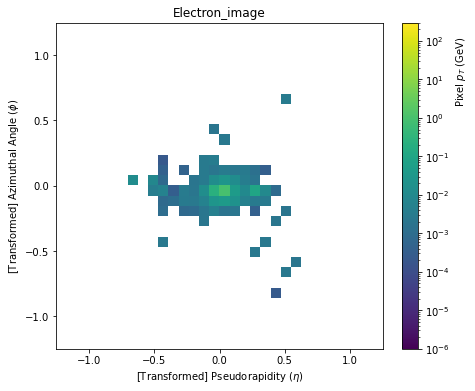

In [ ]:
plot_jet_image(X_e_0[0,:,:],title = 'Electron_image')

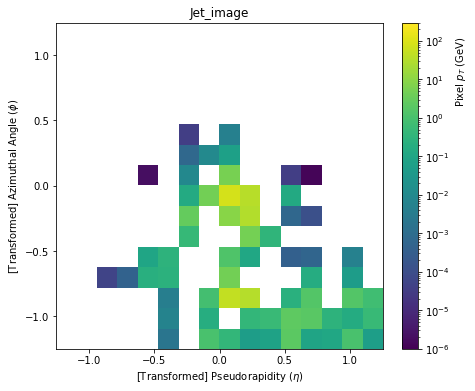

In [ ]:
plot_jet_image(X_jet[0,:,:],title = 'Jet_image')

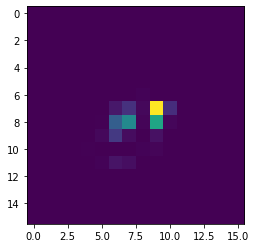

In [ ]:
plt.imshow(X_jet[5,:,:])

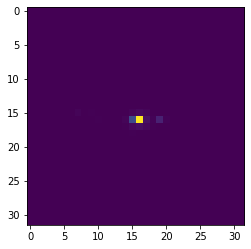

In [ ]:
plt.imshow(X_e_0[0,:,:])

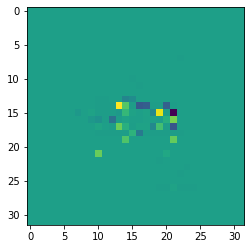

In [ ]:
plt.imshow(X_e_1[0,:,:])

In [ ]:
X_p, y_p = photon_data['X'], photon_data['y']
X_p_0 = X_p[:,:,:,0]
X_p_1 = X_p[:,:,:,1]
print(X_p_0.shape)
print(y_p.shape)

(249000, 32, 32)
(249000,)


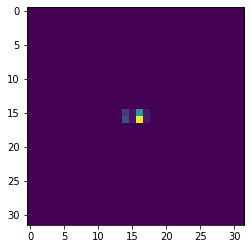

In [ ]:
plt.imshow(X_p_0[0,:,:])

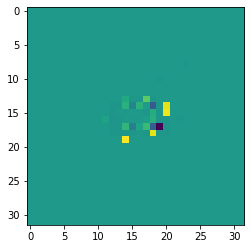

In [ ]:
plt.imshow(X_p_1[0,:,:])

In [ ]:
center = [int(528/32), 528%32]

img_size = 8
X_e_0 = X_e_0[:100, (center[0]-int(img_size/2)):(center[0]+int(img_size/2)), (center[1]-int(img_size/2)):(center[1]+int(img_size/2))]
X_p_0 = X_p_0[:100, (center[0]-int(img_size/2)):(center[0]+int(img_size/2)), (center[1]-int(img_size/2)):(center[1]+int(img_size/2))]

print(X_e_0.shape,X_p_0.shape)

(100, 8, 8) (100, 8, 8)


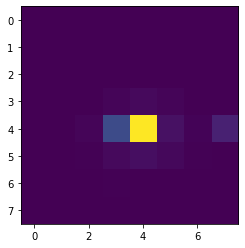

In [ ]:
plt.imshow(X_e_0[0])

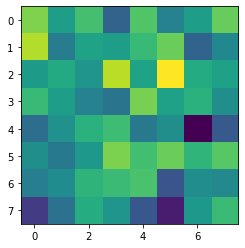

In [ ]:
z_shape = (8,8)
z = tf.random.normal(z_shape)
z = z.numpy()
plt.imshow(z)

# Discriminator


In [ ]:
def one_qubit_unitary(qubit, symbols):
  return cirq.Circuit(
    [cirq.rx(symbols[0])(qubit),
      cirq.ry(symbols[1])(qubit),
      cirq.rz(symbols[2])(qubit)]
  )

In [ ]:
def two_qubit_unitary(qubits):
  cx_ops = [cirq.CX(q0, q1) for q0, q1 in zip(qubits, qubits[1:])]
  cx_ops += ([cirq.CX(qubits[-1], qubits[0])] if len(qubits) != 2 else [])
  return cx_ops

In [ ]:
def pqc_circuit_for_conv(qubits,layers):
  circuit = cirq.Circuit()
  num_qubits = len(qubits)
  input_symbols = sp.symbols('x_:'+str(num_qubits))
  param_symbols = sp.symbols('theta_:'+str(3*num_qubits*layers))
  param_symbols = np.reshape(param_symbols,(layers,num_qubits,3))
  for i in range(num_qubits):
    circuit += cirq.ry(input_symbols[i])(qubits[i])
  
  for layer in range(layers):
    for i,q in enumerate(qubits):
      circuit += one_qubit_unitary(q,param_symbols[layer,i,:])
    circuit += two_qubit_unitary(qubits)
  
  return circuit,input_symbols,list(param_symbols.flat)

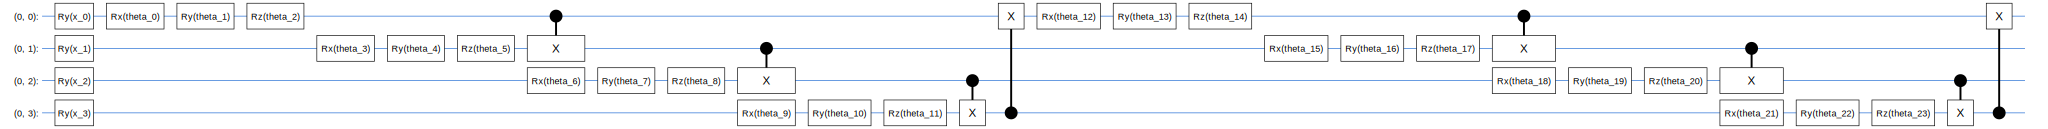

In [ ]:
demo_circuit,i_symbols,p_symbols = pqc_circuit_for_conv(cirq.GridQubit.rect(1,4),layers=2)
SVGCircuit(demo_circuit)

In [ ]:
class QConvPQC(tf.keras.layers.Layer):
   def __init__(self,n_qubits,layers,name='Quantum Convolutional layer'):
     super(QConvPQC,self).__init__(name=name)
     self.num_qubits = n_qubits
    #  self.symbols = symbols
     self.layers = layers
     self.main_name = name
     self.qubits = cirq.GridQubit.rect(1, n_qubits)
     self.observables = cirq.Z(self.qubits[-1])
     circuit, input_symbols, param_symbols = pqc_circuit_for_conv(self.qubits,layers=self.layers)
     param_vals = tf.random_uniform_initializer(minval=-np.pi,maxval=np.pi)
     self.params = tf.Variable(
         initial_value=param_vals(shape=(1,len(param_symbols)),dtype='float32'),
         trainable = True,
         name = self.main_name + '-parameters'
     ) 
     self.empty_circuit = tfq.convert_to_tensor([cirq.Circuit()])

     self.computation_layer = tfq.layers.ControlledPQC(circuit, self.observables)
    
   def get_config(self):
     config = super().get_config().copy()
     config.update({
         'qubit_count':self.num_qubits,
        #  'symbols':self.symbols,
         'layer_count':self.layers,
         'layer_name':self.name
     })
     return config
   def call(self,inputs):
     batch_size = tf.shape(inputs)[0]
     
     inputs_flattened = tf.keras.layers.Flatten()(inputs)
     quantum_inputs = tf.math.atan(inputs_flattened)
     params_batch = tf.tile(self.params, multiples=[batch_size,1], name=self.main_name + '-tiled_up_parameters')
     empty_circuits_batch = tf.repeat(self.empty_circuit, repeats = batch_size, name=self.main_name + '-empty_circuits')
     
     joined_params = tf.concat([quantum_inputs,params_batch],axis=-1)

     return self.computation_layer([empty_circuits_batch,joined_params])

In [ ]:
def QConv_layer(inputs,layers,filter_size,stride,conv_id='',name='QConv_layer_'):
  iter = int(1 + (inputs.shape[1]-filter_size)/stride)
  n_qubits = filter_size*filter_size
  pqc = QConvPQC(n_qubits=n_qubits,layers=layers,name=name+conv_id) # 
  conv = []
  for i in range(iter):
    for j in range(iter):
      temp = pqc(inputs[:,stride*i:filter_size+i*stride,stride*i:filter_size+i*stride])
      conv += [temp]
  output_concat = tf.keras.layers.Concatenate(axis=1)(conv)
  output_reshape = tf.keras.layers.Reshape((iter,iter))(output_concat)
  return output_reshape

# For Electron Photon dataset

In [ ]:
layers = 2
filter_size = [4,3,2]
stride = [2,2,1]

def create_discriminator_e():
  data_inputs = tf.keras.Input(shape=(X_e_0.shape[1], X_e_0.shape[2], ),dtype=tf.dtypes.float32,name='Input_layer')
  conv_1 = QConv_layer(inputs=data_inputs,layers=layers,filter_size=filter_size[0],stride=stride[0],conv_id='1') #
  conv_2 = QConv_layer(inputs=conv_1,layers=layers,filter_size=filter_size[1],stride=stride[1],conv_id='2')  #
  conv_3 = QConv_layer(inputs=conv_2,layers=layers,filter_size=filter_size[2],stride=stride[2],conv_id='3')  #
  conv_output = tf.keras.layers.Flatten()(conv_3)
  normalized_conv_output = tf.keras.layers.BatchNormalization(trainable=True)(conv_output)
  final_output = tf.keras.layers.Dense(1)(normalized_conv_output)
  model = tf.keras.Model(inputs=[data_inputs],outputs=[final_output])
  return model

# For Jet Mass dataset

In [ ]:
layers = 2
filter_size = [4,3,2]
stride = [1,1,1]

def create_discriminator_j():
  data_inputs = tf.keras.Input(shape=(X_jet.shape[1], X_jet.shape[2], ),dtype=tf.dtypes.float32,name='Input_layer')
  conv_1 = QConv_layer(inputs=data_inputs,layers=layers,filter_size=filter_size[0],stride=stride[0],conv_id='1') #
  conv_2 = QConv_layer(inputs=conv_1,layers=layers,filter_size=filter_size[1],stride=stride[1],conv_id='2')  #
  conv_3 = QConv_layer(inputs=conv_2,layers=layers,filter_size=filter_size[2],stride=stride[2],conv_id='3')  #
  conv_output = tf.keras.layers.Flatten()(conv_3)
  normalized_conv_output = tf.keras.layers.BatchNormalization(trainable=True)(conv_output)
  final_output = tf.keras.layers.Dense(1)(normalized_conv_output)
  model = tf.keras.Model(inputs=[data_inputs],outputs=[final_output])
  return model

In [4]:
discriminator_model = create_discriminator_e()
discriminator_model.summary()

# Generator

In [ ]:
def get_output_shape(input_shape,filter_shape,stride,padding='same'):
  if (input_shape[0] % stride[0] == 0):
    pad_along_height = max(filter_shape[0] - stride[0], 0)
  else:
    pad_along_height = max(filter_shape[0] - (input_shape[0] % stride[0]), 0)
  if (input_shape[1] % stride[1] == 0):
    pad_along_width = max(filter_shape[1] - stride[1], 0)
  else:
    pad_along_width = max(filter_shape[1] - (input_shape[1] % stride[1]), 0)
  pad_top = pad_along_height // 2
  pad_bottom = pad_along_height - pad_top
  pad_left = pad_along_width // 2
  pad_right = pad_along_width - pad_left
  paddings = tf.constant([[pad_top,pad_bottom],[pad_left,pad_right]])
  rows = input_shape[0]+paddings[0][0]+paddings[0][1]
  cols = input_shape[1]+paddings[1][0]+paddings[1][1]
  padded_shape = tf.TensorShape([rows,cols])
  new_rows = np.ceil(float(padded_shape[0] - filter_shape[0] + 1) / float(stride[0]))
  new_cols = np.ceil(float(padded_shape[1] - filter_shape[1] + 1) / float(stride[1]))
  return tf.TensorShape([int(new_rows), int(new_cols)])

In [ ]:
class QConv2D_layer(tf.keras.layers.Layer):
  def __init__(self,layers,filters,filter_shape,stride,seed,parameter_sharing=True,padding='same',conv_id='',name='Quantum_Convolutional_Layer_with_padding'):
    super(QConv2D_layer,self).__init__(name=name+conv_id)
    self.layers = layers
    self.filters = filters
    self.parameter_sharing = parameter_sharing
    self.filter_shape = filter_shape
    self.stride = stride
    self.padding = padding
    self.main_name = name
    self.qubits = cirq.GridQubit.rect(1, filter_shape[0]*filter_shape[1])
    self.observables = tfq.convert_to_tensor([cirq.Z(self.qubits[-1])])
    self.circuit, self.input_symbols, self.param_symbols = pqc_circuit_for_conv(self.qubits,layers=self.layers)
    self.model_circuit = tfq.convert_to_tensor([self.circuit])
    self.all_symbols = np.concatenate((self.input_symbols,self.param_symbols),axis=0)
    self.initializer = tf.keras.initializers.RandomUniform(0, 2 * np.pi, seed=seed)
    # self.param_symbols = tf.constant(self.param_symbols)
  
  def build(self,input_shape):
    if len(input_shape) == 3:
      self.input_rows = input_shape[1]
      self.input_cols = input_shape[2]
      self.input_channels = 1
    else:
      self.input_rows = input_shape[1]
      self.input_cols = input_shape[2]
      self.input_channels = input_shape[3]
    output_shape = get_output_shape(input_shape[1:3], self.filter_shape, self.stride, self.padding)
    self.output_rows = output_shape[0]
    self.output_cols = output_shape[1]
    if self.parameter_sharing:
      self.kernel_shape = tf.TensorShape([self.filters, self.input_channels, len(self.param_symbols)])
    else:
      self.kernel_shape = tf.TensorShape([self.filters, self.input_channels, 
                                               self.output_rows,
                                               self.output_cols,
                                               len(self.param_symbols)])
    self.symbol_names = tfq.util.get_circuit_symbols(tfq.from_tensor(self.model_circuit)[0])
    self.kernel = self.add_weight(
                        name='kernel',
                        shape=self.kernel_shape,
                        initializer=self.initializer,
                        # regularizer=self.regularizer,
                        # constraint=self.constraint,
                        trainable=True,
                        dtype=self.dtype)
    self.inputs_preprocess_ = self.inputs_preprocess()
  
  def inputs_preprocess(self):
      kernel_size = (1, 1) + self.filter_shape + (1,)
      strides = (1, 1) + self.stride + (1,)
      padding = self.padding.upper()
      batchsize = lambda x: tf.gather(tf.shape(x), 0)
      # planes = number of channels
      planes = self.input_channels
      rows = self.input_rows
      cols = self.input_cols
      depth = 1
      reshaped_input_ = lambda x: tf.reshape(x, shape=(batchsize(x), rows, cols, planes))
    # change input order to (batchsize, depth, rows, cols)
      transposed_input = lambda x: tf.transpose(reshaped_input_(x), [0, 3, 1, 2])
      reshaped_input = lambda x: tf.reshape(transposed_input(x), 
                                              shape=(batchsize(x), planes, rows, cols, depth))
      input_patches = lambda x: tf.extract_volume_patches(reshaped_input(x),
                                            ksizes=kernel_size, strides=strides, padding=padding)
      return input_patches 

    
  def call(self,inputs):
    batchsize = tf.gather(tf.shape(inputs), 0)
    depth = self.input_channels
    rows = self.output_rows
    cols = self.output_cols

    input_patches = self.inputs_preprocess_(inputs)
    # resolved_inputs__ = self._input_resolver(inputs)
    inputs = tf.reshape(input_patches, [batchsize, depth, 
                                      self.output_rows, 
                                      self.output_cols,
                                      len(self.input_symbols)])
        # change to (depth, batchsize, rows, cols, symbols)
    inputs = tf.transpose(inputs, [1, 0, 2, 3, 4])
        # total number of circuit = filters*depth*batchsize*rows*cols
    circuit_size = tf.reduce_prod([self.filters, batchsize, depth, rows, cols])
        # tile inputs to (filters, depth, batchsize, rows, cols, symbols)
    tiled_up_inputs = tf.tile([inputs], [self.filters, 1, 1, 1, 1, 1])
        # reshape inputs to (circuit_size, symbols)
    tiled_up_inputs = tf.reshape(tiled_up_inputs, (circuit_size, tf.shape(tiled_up_inputs)[-1]))
    if self.parameter_sharing:
      # tile size for weights = batchsize*rows*cols
      tile_size = tf.reduce_prod([batchsize, rows, cols])
      tiled_up_weights__ = tf.tile([self.kernel], [tile_size, 1, 1, 1])
      # change to (filters, depth, batchsize*rows*cols, weight_symbols)
      tiled_up_weights_ = tf.transpose(tiled_up_weights__, [1, 2, 0, 3])
    else:
      # tile size for weights = batchsize
      # weight now has shape (batchsize, filters, depth, rows, cols, weight_symbols)
      tiled_up_weights__ = tf.tile([self.kernel], [batchsize, 1, 1, 1, 1, 1])
      # change to (filters, depth, batchsize, rows, cols, weight_symbols)
      tiled_up_weights_ = tf.transpose(tiled_up_weights__, [1, 2, 0, 3, 4, 5])
      # reshape to (circuit_size, weight_symbols)
    tiled_up_weights = tf.reshape(tiled_up_weights_, (circuit_size, tf.shape(tiled_up_weights_)[-1]))
    tiled_up_parameters = tf.concat([tiled_up_inputs, tiled_up_weights], 1)
        
    # tiled_up_data_circuit = tf.tile(self._data_circuit, [circuit_size])
    tiled_up_circuits = tf.tile(self.model_circuit, [circuit_size])
    # model_appended = self._append_layer(tiled_up_data_circuit, append=tiled_up_model)
    tiled_up_operators = tf.tile([self.observables], [circuit_size, 1])
    
    result = tfq.layers.Expectation()(tiled_up_circuits,
                                    symbol_names=self.symbol_names,
                                    symbol_values=tiled_up_parameters,
                                    operators=tiled_up_operators)

    reshaped_output = tf.reshape(result,(self.filters, self.input_channels, batchsize, self.output_rows, self.output_cols))
    summed_output = tf.reduce_mean(reshaped_output, axis=1)
    final_output = tf.transpose(summed_output, [1, 2, 3, 0])
    return tf.reshape(final_output, (batchsize, self.output_rows, self.output_cols, self.filters))

# For Electron Photon dataset

In [ ]:
def create_generator_e():
  model = tf.keras.Sequential(name = 'Generator')
  model.add(tf.keras.layers.Input(shape=(256), dtype=tf.float32))
  model.add(tf.keras.layers.Reshape((16, 16, 1)))
  model.add(QConv2D_layer(layers=1, filter_shape=(3, 3),conv_id ='1',
                      filters=2, stride=(1, 1), padding="same", parameter_sharing=True,seed=2021,
                      ))
  model.add(QConv2D_layer(layers=2, filter_shape=(2, 2),conv_id = '2',
                      filters=1, stride=(1, 1), padding="same", parameter_sharing=True,seed=2022,
                      ))
  return model

# For Jet Mass dataset

In [ ]:
def create_generator_j():
  model = tf.keras.Sequential(name = 'Generator')
  model.add(tf.keras.layers.Input(shape=(64), dtype=tf.float32))
  model.add(tf.keras.layers.Reshape((8, 8, 1)))
  model.add(QConv2D_layer(layers=1, filter_shape=(3, 3),conv_id ='1',
                      filters=2, stride=(1, 1), padding="same", parameter_sharing=False,seed=2021,
                      ))
  model.add(QConv2D_layer(layers=2, filter_shape=(2, 2),conv_id = '2',
                      filters=1, stride=(1, 1), padding="same", parameter_sharing=True,seed=2022,
                      ))
  return model

In [ ]:
generator_model = create_generator_j()
generator_model.summary()

Model: "Generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape_3 (Reshape)         (None, 8, 8, 1)           0         
                                                                 
 Quantum_Convolutional_Layer  (None, 8, 8, 2)          54        
 _with_padding1 (QConv2D_lay                                     
 er)                                                             
                                                                 
 Quantum_Convolutional_Layer  (None, 8, 8, 1)          48        
 _with_padding2 (QConv2D_lay                                     
 er)                                                             
                                                                 
Total params: 102
Trainable params: 102
Non-trainable params: 0
_________________________________________________________________


In [ ]:
class QGAN():
  def __init__(self,discriminator,generator,disc_optimizer,gen_optimizer):
    self.generator_model = generator
    self.discriminator_model = discriminator
    self.d_opt = disc_optimizer
    self.g_opt = gen_optimizer
    # self.g_lr = gen_learning_rate
    # self.d_lr = disc_learning_rate
    self.loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
    self.gen_loss_ = []
    self.disc_loss_ = []
    self.epochs_ = []
    # self.d_opt = self.d_opt(self.d_lr)
    # self.g_opt = self.g_opt(self.g_lr)

  def prepare_dataset(self,data,batch_size,seed=None,drop_remainder=True,buffer_size=100):
    buffer_size =len(data[0])
    ds = tf.data.Dataset.from_tensor_slices(data)
    ds = ds.shuffle(buffer_size=buffer_size,seed=seed,reshuffle_each_iteration=True)
    ds = ds.batch(batch_size,drop_remainder)
    ds = ds.prefetch(tf.data.AUTOTUNE)
    return ds

  def train_preprocess(self,random_state):
    tf.random.set_seed(random_state)
    np.random.seed(random_state)
  
  @tf.function
  def generator_loss(self,fake_output):
    return self.loss(tf.ones_like(fake_output),fake_output)

  @tf.function
  def discriminator_loss(self,real_output,fake_output):
    real_loss = self.loss(tf.ones_like(real_output),real_output)
    fake_loss = self.loss(tf.zeros_like(fake_output),fake_output)
    return real_loss + fake_loss
  
  @tf.function
  def train_step_1v1(self,x_real,batch_size):
    """Training step for one epoch with 1 generator step and 1 discriminator step
        """
    fake_data_shape = (batch_size,) + self.generator_model.input_shape[1:]
    z = tf.random.normal(shape=fake_data_shape)
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      x_fake_ = self.generator_model(z, training=True)
      # x_fake = tf.reshape(x_fake_, tf.shape(x_real))
      real_output = self.discriminator_model(x_real, training=True)
      fake_output = self.discriminator_model(x_fake_, training=True)
      gen_loss = self.generator_loss(fake_output)
      disc_loss = self.discriminator_loss(real_output, fake_output)
    grad_gen = gen_tape.gradient(gen_loss, self.generator_model.trainable_variables)
    grad_disc = disc_tape.gradient(disc_loss, self.discriminator_model.trainable_variables)
    self.g_opt.apply_gradients(zip(grad_gen, self.generator_model.trainable_variables))
    self.d_opt.apply_gradients(zip(grad_disc, self.discriminator_model.trainable_variables))  
    return gen_loss, disc_loss

  @tf.function
  def train_step_nv1(self,x_real,n_disc,batch_size):
    for i in range(n_disc):
      x_real_batch = tf.gather(x_real,i)
      d_loss = self.discriminator_step(x_real_batch,batch_size)
    g_loss = self.generator_step(batch_size)
    return g_loss, d_loss

  @tf.function
  def train_step_1vn(self,x_real,n_gen,batch_size):
    for i in range(n_gen):
      g_loss = self.generator_step(batch_size)
    d_loss = self.discriminator_step(x_real,batch_size)
    return g_loss, d_loss 

  @tf.function
  def discriminator_step(self,x_real,batch_size):
    fake_data_shape = (batch_size,) + self.generator_model.input_shape[1:]
    # x_real = tf.reshape(x_real,fake_data_shape)
    z = tf.random.normal(shape=fake_data_shape)
    with tf.GradientTape() as gradient_tape:
      real_output = self.discriminator_model(x_real,training = True)
      fake_input = self.generator_model(z, training = True) 
      # fake_input = tf.reshape(fake_input, tf.shape(x_real))
      fake_output = self.discriminator_model(fake_input,training = True)
      cost = self.discriminator_loss(real_output,fake_output)
    grad = gradient_tape.gradient(cost,self.discriminator_model.trainable_variables)
    self.d_opt.apply_gradients(zip(grad,self.discriminator_model.trainable_variables))
    return cost

  @tf.function
  def generator_step(self,batch_size):
    fake_data_shape = (batch_size,) + self.generator_model.input_shape[1:]
    z = tf.random.normal(shape=fake_data_shape)
    with tf.GradientTape() as gradient_tape:
      fake_input = self.generator_model(z,training=True)
      fake_output = self.discriminator_model(fake_input,training= True) #
      loss = self.generator_loss(fake_output)
    grad = gradient_tape.gradient(loss,self.generator_model.trainable_variables)
    self.g_opt.apply_gradients(zip(grad,self.generator_model.trainable_variables))
    return loss
  
  def train_qgans(self,x,epochs,batch_size,seed=1024,n_disc=1,n_gen=1):
    input_shape = x.shape[1:]
    self.train_preprocess(seed)
    data = self.prepare_dataset(data=x,batch_size=batch_size*n_disc,seed=seed)
    g_metric = tf.keras.metrics.Mean()
    d_metric = tf.keras.metrics.Mean()
    for epoch in range(epochs):
      for step,training_batch_data_ in enumerate(data):
        # training_batch_data = tf.reshape(training_batch_data_,input_batch_shape)
        if( n_disc == 1 and n_gen == 1):
          input_batch_shape = (batch_size,) + input_shape
          training_batch_data = tf.reshape(training_batch_data_,input_batch_shape)
          gen_loss,disc_loss = self.train_step_1v1(x_real=training_batch_data, batch_size=batch_size)
        if n_disc > 1 and n_gen == 1:
          input_batch_shape = (n_disc, batch_size) + input_shape
          training_batch_data = tf.reshape(training_batch_data_,input_batch_shape)        
          gen_loss,disc_loss = self.train_step_nv1(x_real=training_batch_data, batch_size=batch_size,n_disc=n_disc)
        if n_gen > 1 and n_disc == 1:
          input_batch_shape = (batch_size,) + input_shape
          training_batch_data = tf.reshape(training_batch_data_,input_batch_shape)
          gen_loss,disc_loss = self.train_step_1vn(x_real=training_batch_data, batch_size=batch_size,n_gen=n_gen)
        g_metric(gen_loss)
        d_metric(disc_loss)
      self.gen_loss_.append(g_metric.result().numpy())
      self.disc_loss_.append(d_metric.result().numpy())
      self.epochs_.append(epoch)
      print("Epoch:{} ;   generator_loss:{} ;   discriminator_loss:{}".format(epoch,g_metric.result().numpy(),d_metric.result().numpy()))
  
      g_metric.reset_state()
      d_metric.reset_state()
    return self.gen_loss_,self.disc_loss_,self.epochs_

  def generate_samples(self,batch_size, shape=None):
    """Generates sample using random inputs
        
            Arguments:
                batch_size: int
                    Number of samples to generate.
                shape: (Optional) tuple of int
                    Reshape the output to the given shape.
        """
    z_batch_shape = (batch_size,) + self.generator_model.input_shape[1:]
    z = tf.random.normal(z_batch_shape)
    print(z.shape[0])
    samples = self.generator_model(z,training = False)
    # samples = generator_model
    # if shape is not None:
    #   shape = (batch_size,) + shape
    #   samples = tf.reshape(samples, shape)
    return samples

  def predict(self, x):
    return self.discriminator_model(x, training=False)

In [ ]:
fake_data_shape = (10000,) + generator_model.input_shape[1:]
print(fake_data_shape)
print(generator_model.output_shape)
print(discriminator_model.input_shape)

(10000, 64)
(None, 8, 8, 1)
(None, 8, 8)


In [ ]:
d_optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.1)
g_optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.5)
model = QGAN(generator=generator_model,discriminator=discriminator_model,disc_optimizer=d_optimizer,gen_optimizer=g_optimizer)

In [ ]:
X_jet_final = np.reshape(X_jet, (X_jet.shape[0], 8, 8, 1))
gen_loss_,disc_loss_,epochs_ = model.train_qgans(X_jet,epochs=25,batch_size=20,seed=2021)

Epoch:0 ;   generator_loss:0.6921666264533997 ;   discriminator_loss:1.38629949092865
Epoch:1 ;   generator_loss:0.6931473016738892 ;   discriminator_loss:1.3862943649291992
Epoch:2 ;   generator_loss:0.6931471824645996 ;   discriminator_loss:1.3862943649291992
Epoch:3 ;   generator_loss:0.6931471824645996 ;   discriminator_loss:1.3862943649291992
Epoch:4 ;   generator_loss:0.6931467056274414 ;   discriminator_loss:1.3862943649291992
Epoch:5 ;   generator_loss:0.6931949257850647 ;   discriminator_loss:1.3862943649291992
Epoch:6 ;   generator_loss:0.6931001543998718 ;   discriminator_loss:1.3862968683242798
Epoch:7 ;   generator_loss:0.6932069659233093 ;   discriminator_loss:1.3862943649291992
Epoch:8 ;   generator_loss:0.6930819749832153 ;   discriminator_loss:1.3862943649291992
Epoch:9 ;   generator_loss:0.6933065056800842 ;   discriminator_loss:1.3862957954406738
Epoch:10 ;   generator_loss:0.6929985880851746 ;   discriminator_loss:1.386294960975647
Epoch:11 ;   generator_loss:0.6932

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

def plot_loss(gen_loss,disc_loss,epochs):
  fig = plt.figure(figsize=(16,9))
  gs = gridspec.GridSpec(ncols=8, nrows=8, figure=fig)
  epoch = epochs[-1]
  # plot loss curve
  ax_loss = plt.subplot(gs[:,:4])
  ax_loss.set_xlim(0, 1.1*epoch)
  ax_loss.plot(epochs, gen_loss, label="Generator")
  ax_loss.plot(epochs, disc_loss, label="Discriminator")
  ax_loss.set_xlabel('Epoch', fontsize=20)
  ax_loss.set_ylabel('Loss', fontsize=20)
  ax_loss.grid(True)
  ax_loss.legend(fontsize=15)

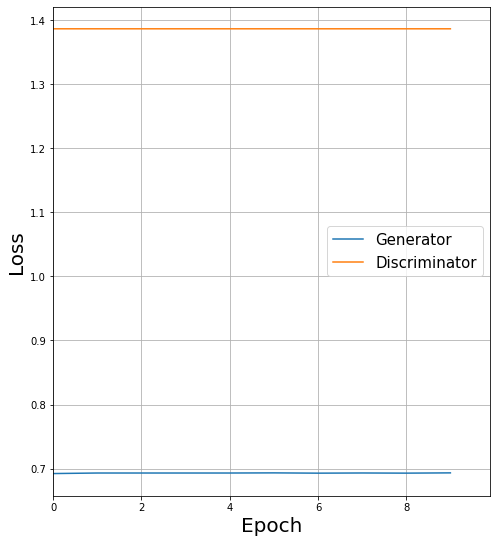

In [ ]:
plot_loss(gen_loss_,disc_loss_,epochs_)

8


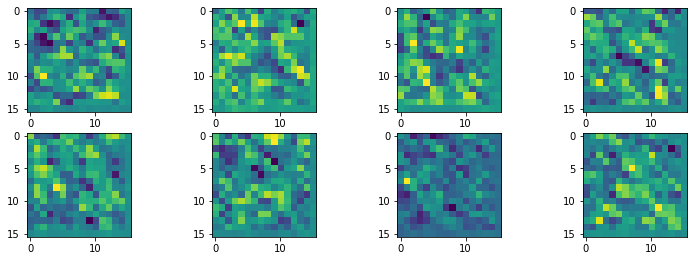

In [ ]:
n_images = 8
samples = np.reshape(np.array(model.generate_samples(batch_size=n_images,shape=(5,))),(n_images,8,8))
fig = plt.figure(figsize=(26,18))
gs = gridspec.GridSpec(ncols=8, nrows=8, figure=fig)
for i in range(samples.shape[0]):
  ax = plt.subplot(gs[i//4, 4 + i%4])
  plt.imshow(samples[i])